In [20]:
import os
import sys
import csv
import Image
import glob
import random
import pylab
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline
pylab.rcParams['figure.figsize'] = (7.0, 5.0)

In [2]:
IN_IMGS_DIR = "/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/Challenge2_Training_Task12_Images"
IN_GT_DIR = "/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/Challenge2_Training_Task1_GT"
OUT_IMGS_DIR = "/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/scaled_imgs"
OUT_GT_DIR = "/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/scaled_gts"

In [11]:
img_files = os.listdir(IN_IMGS_DIR)
gt_files = os.listdir(IN_GT_DIR)
img_files.sort()
gt_files.sort()

for img_file, gt_file in tqdm(zip(img_files, gt_files)):
    img_path = os.path.join(IN_IMGS_DIR, img_file)
    gt_path = os.path.join(IN_GT_DIR, gt_file)
    out_img_path = os.path.join(OUT_IMGS_DIR, img_file)
    out_gt_path = os.path.join(OUT_GT_DIR, gt_file)
    
    img = Image.open(img_path)
    old_w, old_h = img.size
    
    # Resize image
    if old_w > old_h:
        img = img.resize((int((600. / old_h) * old_w) , 600), Image.BILINEAR)
    else:
        img = img.resize((600, int((600. / old_w) * old_h)), Image.BILINEAR)
        
    new_w, new_h = img.size
        
    # Scale bounding boxes
    anns = []
    with open(gt_path) as f:
        for line in f:
            l, t, r, b, word = line.rstrip('\r\n').split(" ")
            word = word.replace("\"", "")
            
            l = float(l) * (float(new_w) / old_w)
            r = float(r) * (float(new_w) / old_w)
            t = float(t) * (float(new_h) / old_h)
            b = float(b) * (float(new_h) / old_h)
            
            anns.append([l, t, r, b, word])
    
    # Save image and bounding boxes
    img.save(out_img_path)
    with open(out_gt_path, "w") as f:
        writer = csv.writer(f, delimiter=" ")
        writer.writerows(anns)
    

100%|██████████| 229/229 [00:12<00:00, 15.89it/s]


In [17]:
def show_anns(anns):
    """Display the specified annotations."""
    if len(anns) == 0:
        return 0
    
    ax = plt.gca()
    rectangles = []
    color = []
    for ann in anns:
        c = np.random.random((1,3)).tolist()[0]
        left, bottom, width, height = ann['bbox']
        rectangles.append(Rectangle([left, bottom], width, height, alpha=0.4))
        color.append(c)
        if 'word' in ann.keys():
            ax.annotate(ann['word'], xy=(left,bottom + height), color=c)
    
    p = PatchCollection(rectangles, facecolors=color, edgecolors=(0,0,0,1),
                       linewidths=3, alpha=0.4)
    ax.add_collection(p)

In [13]:
imgs = glob.glob(join(OUT_IMGS_DIR, "*.jpg"))
gts = glob.glob(join(OUT_GT_DIR, "*.txt"))
imgs.sort()
gts.sort()

dataset = []
for img, gt in zip(imgs, gts):
    sample = {}
    sample["img"] = img
    
    anns = []
    with open(gt) as f:
        for line in f:
            _left, _top, _right, _bottom, word = line.rstrip('\r\n').split(" ")
            left = float(_left); top = float(_top); 
            right = float(_right); bottom = float(_bottom)
            width = right - left
            height = top - bottom
            
            word = word.lower()
            ann = {"bbox": (left, bottom, width, height),
                  "word": word}
            anns.append(ann)
            
    sample["anns"] = anns
    
    dataset.append(sample)

/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/scaled_imgs/273.jpg


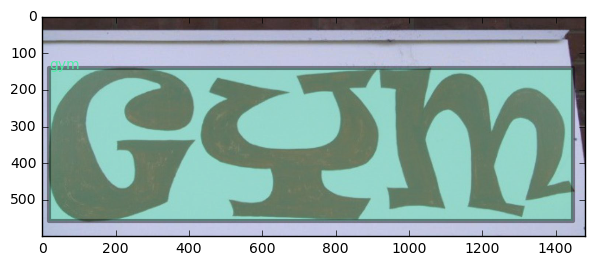

In [25]:
sample_id = random.randint(0, len(dataset)-1)
I = io.imread(dataset[sample_id]['img'])
print dataset[sample_id]['img']
plt.figure()
plt.imshow(I)
show_anns(dataset[sample_id]['anns'])